# U-Net Baseline

Just for added clarity: please run in Python 3.10 with tensorflow 2.13.0, numpy 1.24.3, matplotlib 3.7.3. For simplicity just run ``` pip install -r requirements.txt ```.

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import sklearn

**Defining Model and Loss Functions**

In [3]:
smooth = 1e-6
def dice_coeff(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - tf.compat.v1.reduce_mean(dice_coeff(y_true, y_pred))

In [6]:
import keras.backend as K
smooth_iou = 0.001

def jacard_coeff(y_true,y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    i = K.sum(y_true_f * y_pred_f) + smooth_iou
    u = K.sum(y_true) + K.sum(y_pred) - i + smooth_iou
    iou = i/u
    return iou
def jacard_coeff_loss(y_true,y_pred):
    return 1.0-jacard_coeff(y_true,y_pred)

In [ ]:
# import our model
from keras.utils import custom_object_scope

with custom_object_scope({'dice_loss': dice_loss, 'dice_coeff': dice_coeff, 'jacard_coeff': jacard_coeff}):
    # Load your model
    model = tf.keras.models.load_model('Brain_hemorrhage_model_mask.h5')

**Preprocessing Data**

In [52]:
IMG_SIZE = 128

def preprocess(image_path, mask_path):
    # Read and resize grayscale image, convert to RGB
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_rgb = img_rgb.astype(np.float32) / 255.0

    # Read and resize mask, binarize
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = (mask > 127).astype(np.float32)  # binary mask

    return img_rgb, mask[..., np.newaxis]

In [53]:
def load_dataset(image_dir, mask_dir):
    image_files = sorted(os.listdir(image_dir))
    X, Y = [], []

    for fname in image_files:
        image_path = os.path.join(image_dir, fname)
        mask_name = fname.replace('.jpg', '_HGE_Seg.jpg')
        mask_path = os.path.join(mask_dir, mask_name)

        if os.path.exists(mask_path):
            img, mask = preprocess(image_path, mask_path)
            X.append(img)
            Y.append(mask)

    return np.array(X), np.array(Y)


In [54]:
from sklearn.model_selection import train_test_split

X, Y = load_dataset('hemorrhage_CT/images', 'hemorrhage_CT/masks')
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

In [55]:
def make_tf_dataset(X, Y, batch_size=8, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X))
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_dataset = make_tf_dataset(X_train, Y_train)
val_dataset = make_tf_dataset(X_val, Y_val, shuffle=False)
test_dataset = make_tf_dataset(X_test, Y_test, shuffle=False)

In [ ]:
# Optional: freeze early layers
for layer in model.layers[:-10]:
    layer.trainable = False

model.compile(optimizer='adam',
              loss=dice_loss,
              metrics=[dice_coeff, jacard_coeff])

# --- Train ---
model.fit(train_dataset,
          validation_data=val_dataset,
          epochs=1000,  # Arbitrary high value; training will stop early
          callbacks=[
              tf.keras.callbacks.ModelCheckpoint('ICH_seg_model.h5', save_best_only=True),
              tf.keras.callbacks.EarlyStopping(
                  monitor='val_loss',
                  patience=3,                # Wait 3 epochs before stopping
                  restore_best_weights=True,
                  verbose=1
              )
          ])

# --- Evaluate ---
loss, dice, jaccard = model.evaluate(test_dataset)
print(f"Test Dice Coeff: {dice:.4f}, Jaccard: {jaccard:.4f}")

Epoch 1/1000
28/28 [==============================] - 24s 833ms/step - loss: 0.6482 - dice_coeff: 0.3865 - jacard_coeff: 0.2545 - val_loss: 0.8690 - val_dice_coeff: 0.1655 - val_jacard_coeff: 0.0919
Epoch 2/1000
28/28 [==============================] - 24s 861ms/step - loss: 0.6594 - dice_coeff: 0.3747 - jacard_coeff: 0.2509 - val_loss: 0.9156 - val_dice_coeff: 0.1172 - val_jacard_coeff: 0.0630
Epoch 3/1000
28/28 [==============================] - 25s 901ms/step - loss: 0.6515 - dice_coeff: 0.3809 - jacard_coeff: 0.2516 - val_loss: 0.8939 - val_dice_coeff: 0.1380 - val_jacard_coeff: 0.0752
Epoch 4/1000
28/28 [==============================] - 26s 934ms/step - loss: 0.6367 - dice_coeff: 0.3987 - jacard_coeff: 0.2706 - val_loss: 0.9108 - val_dice_coeff: 0.1202 - val_jacard_coeff: 0.0648
Epoch 4: early stopping
6/6 [==============================] - 3s 534ms/step - loss: 0.8418 - dice_coeff: 0.1928 - jacard_coeff: 0.1096
Test Dice Coeff: 0.1928, Jaccard: 0.1096


In [64]:
import random
import matplotlib.pyplot as plt

def visualize_prediction(model, image_dir, mask_dir, img_size=128):
    image_files = sorted(os.listdir(image_dir))
    sample_file = random.choice(image_files)

    # Paths for image and mask
    img_path = os.path.join(image_dir, sample_file)
    mask_path = os.path.join(mask_dir, sample_file.replace('.jpg', '_HGE_Seg.jpg'))

    if not os.path.exists(mask_path):
        print(f"No mask found for {sample_file}. Skipping.")
        return

    # Preprocess
    img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img_gray, (img_size, img_size))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB).astype(np.float32) / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask_resized = cv2.resize(mask, (img_size, img_size))
    mask_bin = (mask_resized > 127).astype(np.uint8)

    # Predict
    input_img = np.expand_dims(img_rgb, axis=0)  # add batch dimension
    pred = model.predict(input_img)[0].squeeze().round()

    # Overlay for GT mask
    overlay_gt = img_rgb.copy()
    overlay_gt[mask_bin == 1] = [1.0, 0.0, 0.0]  # red

    # Overlay for predicted mask
    overlay_pred = img_rgb.copy()
    overlay_pred[pred == 1] = [0.0, 1.0, 0.0]  # green

    # Plot
    fig, axs = plt.subplots(1, 4, figsize=(18, 6))
    axs[0].imshow(img_rgb)
    axs[0].set_title('Original Image')
    axs[1].imshow(mask_bin, cmap='gray')
    axs[1].set_title('Ground Truth Mask')
    axs[2].imshow(pred, cmap='gray')
    axs[2].set_title('Predicted Mask')
    axs[3].imshow(overlay_gt)
    axs[3].imshow(pred, cmap='Greens', alpha=0.5)
    axs[3].set_title('Overlay: GT (Red) + Pred (Green)')

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 250ms/step


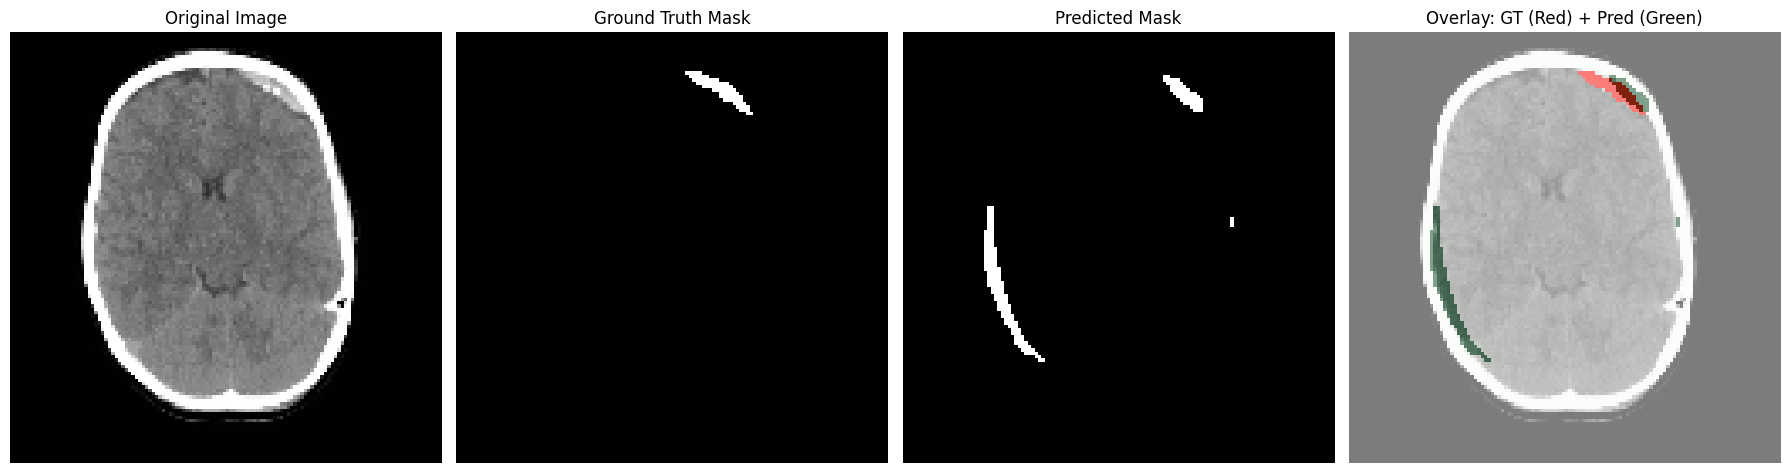

In [65]:
visualize_prediction(model, 'hemorrhage_CT/images', 'hemorrhage_CT/masks')

# Evaluating Our Model

We define a new function ``` binary_overlap_score ``` that will tell us in a binary fashion whether or not the U-net model predicted the hemorrhage in the right area. This is definitely an over-simplification but since our RL agent will be graded the same way (i.e. whether or not it lands in the ground-truth segementation or not), it is only fair for the u-net model to be graded the same way for easier comparison.

In [60]:
from fractions import Fraction

def binary_overlap_score(model, image_dir, mask_dir, img_size=128):
    image_files = sorted(os.listdir(image_dir))
    total = 0
    correct = 0

    for fname in image_files:
        img_path = os.path.join(image_dir, fname)
        mask_name = fname.replace('.jpg', '_HGE_Seg.jpg')
        mask_path = os.path.join(mask_dir, mask_name)

        if not os.path.exists(mask_path):
            continue  # skip unmatched files

        # Preprocess input and ground truth
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB).astype(np.float32) / 255.0

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (img_size, img_size))
        mask_bin = (mask > 127).astype(np.uint8)

        # Predict
        pred = model.predict(np.expand_dims(img_rgb, axis=0))[0].squeeze().round().astype(np.uint8)

        # Check if there's any overlap
        overlap = np.logical_and(pred, mask_bin).any()

        total += 1
        if overlap:
            correct += 1

    print(f"Binary overlap score: {correct}/{total}")
    return f"{correct}/{total}", Fraction(correct, total)

In [66]:
score_str, score_frac = binary_overlap_score(model, 'hemorrhage_CT/images', 'hemorrhage_CT/masks')

1/1 [==============================] - 0s 83ms/step
Binary overlap score: 210/318
